In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import joblib
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
from datasets import load_dataset
dataset = load_dataset("MahiA/RAVDESS")
train_data = dataset['train']



e:\speech_analytics_system_for_contact_centres\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(train_data)
print(train_data[0])

Dataset({
    features: ['path', 'classname'],
    num_rows: 1961
})
{'path': 'audios/03-02-06-02-02-01-03.wav', 'classname': 'fearful'}


Problem:

Models don’t understand file paths.

Solution:

Convert physical sound → numerical time series.

Why this works

librosa.load:

opens .wav

decodes PCM

converts to float

resamples to 16kHz

In [4]:
def load_audio(file_path, target_sr = 16000):
    waveform, sr = librosa.load(file_path, sr = target_sr) # waveform is a 1D numpy array of audio samples that has been resampled to target_sr means 16kHz , resampling means changing the sample rate of the audio signal to a desired value. and this waveform is now ready for further processing or analysis. its only for loading audio file that too only 1 file at a time.
    return waveform,sr

Why we need features

Waveform is:

too long

sensitive to noise

not frequency-aware

Emotion lives in frequency patterns, not raw amplitude.

In [5]:
def extract_mfcc(audio_array, sr):
    mfcc = librosa.feature.mfcc(y=audio_array, 
                                sr=sr,
                                n_mfcc = 40)
    return np.mean(mfcc,axis = 1)

MFCCs (Mel-frequency cepstral coefficients) are used in speech recognition because they effectively represent the essential frequency characteristics of sound in a compact and robust way, making it easier for machine learning models to distinguish between different phonemes and words

Why MFCC specifically?

MFCC approximates:

how humans hear sound

pitch & timbre

emotional cues

Used historically in:

call centers

IVR

telecom analytics


Why mean pooling?

Audio lengths vary:

1.5s

2.1s

3s

Models need fixed-size input.

Mean pooling compresses:

(40, T) → (40,)


This preserves global spectral characteristics.

In [6]:
emotion_map = {
    'neutral':0,
    'calm':1,
    'happy':2,
    'sad':3,
    'angry':4,
    'fearful':5,
    'disgust':6,
    'surprised':7
    }

## Alternative: Use a Smaller Dataset or Streaming
Since RAVDESS is large (~4GB unzipped for speech), consider these options:

1. **Use a subset**: Download only a few actors' data from RAVDESS to test your code.
2. **Use an external drive**: Store the dataset on an external USB drive and update the paths.
3. **Use a different dataset**: Try a smaller emotion dataset from Hugging Face, like:
   - `google/speech_commands` (smaller audio commands dataset)
   - Or search for "emotion" in HF datasets for text-based alternatives if audio isn't critical.

4. **Cloud option**: Run this in Google Colab where you can mount Google Drive for storage.

## Note on Dataset
The Hugging Face dataset "MahiA/RAVDESS" only contains the metadata (CSV files with paths and labels). The actual audio files are not hosted on Hugging Face due to size (RAVDESS is ~24GB).

To use this dataset, you need to download the RAVDESS audio files from the original source: https://zenodo.org/records/1188976

After downloading, extract the files and place the `Audio_Speech_Actors_01-24` folder (or similar) such that the paths in the dataset match. The paths are relative like 'audios/03-02-06-02-02-01-03.wav', so you may need to adjust the folder structure or modify the paths.

Alternatively, you can modify the dataset loading to point to the correct local paths.

In [16]:
BASE_DIR = os.path.join(os.getcwd(), "..", "..", "Audio_Speech_Actors_01-24")

def resolve_path(sample):
    filename = sample["path"].split("/")[-1]
    actor = filename.split("-")[-1].split(".")[0]
    actor_dir = f"Actor_{actor}"
    return os.path.join(BASE_DIR, actor_dir, filename)

In [17]:
X = []
y = []

for sample in train_data:
    filename = sample["path"].split("/")[-1]
    vocal_channel = filename.split('-')[1]
    if vocal_channel != '01':
        continue  # Only speech
    path = resolve_path(sample)
    waveform, sr = load_audio(path)
    features = extract_mfcc(waveform, sr)
    
    X.append(features)
    y.append(emotion_map[sample["classname"]])

print(f"Loaded {len(X)} samples")


Loaded 1146 samples


In [18]:
X

[array([-6.4859772e+02,  5.3118851e+01, -3.4520266e+00,  9.7389212e+00,
        -4.6553855e+00, -1.2768232e+00, -6.9486957e+00, -9.2587376e+00,
        -5.4624839e+00, -6.3016472e+00, -2.9603727e+00, -8.3322353e+00,
        -1.7346956e+00, -6.2013584e-01, -9.8009787e+00, -3.9474697e+00,
        -4.6298780e+00, -4.2009854e+00, -4.2480302e+00, -3.0016437e+00,
        -3.8485615e+00,  5.8148897e-01,  6.9520247e-01,  4.2981801e+00,
         3.6253765e+00,  3.6546912e+00,  3.0807641e+00,  5.3086395e+00,
         3.3020585e+00,  6.2360411e+00,  5.0736222e+00,  8.1609735e+00,
         4.4882584e+00,  6.9304647e+00,  1.7038001e+00,  1.4130900e+00,
         7.5940871e-01,  3.1757352e+00,  4.4750443e-01,  1.7424268e+00],
       dtype=float32),
 array([-6.06316040e+02,  3.61327400e+01, -5.80707598e+00,  7.51830482e+00,
        -2.30980372e+00, -1.16618385e+01, -1.41430864e+01, -1.63853054e+01,
        -8.70736694e+00, -5.12155342e+00, -1.08851032e+01, -6.27601624e-01,
        -7.56263399e+00,  6.

In [19]:
X = np.array(X)
y = np.array(y)

In [20]:
X.shape, y.shape

((1146, 40), (1146,))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(916, 40) (230, 40) (916,) (230,)


In [22]:
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'linear'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",True
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [23]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy", acc)

Accuracy 0.45217391304347826


In [24]:
classification_report = classification_report(y_test, y_pred)
print(classification_report)

              precision    recall  f1-score   support

           0       0.32      0.39      0.35        18
           1       0.54      0.60      0.57        25
           2       0.48      0.41      0.44        32
           3       0.38      0.37      0.38        27
           4       0.64      0.72      0.68        29
           5       0.41      0.47      0.44        30
           6       0.33      0.25      0.29        36
           7       0.45      0.45      0.45        33

    accuracy                           0.45       230
   macro avg       0.44      0.46      0.45       230
weighted avg       0.45      0.45      0.45       230



In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[ 7  2  1  4  0  1  1  2]
 [ 5 15  0  3  0  0  2  0]
 [ 3  0 13  3  2  7  2  2]
 [ 2  6  1 10  0  5  2  1]
 [ 0  0  2  0 21  0  4  2]
 [ 1  0  6  3  1 14  1  4]
 [ 1  2  2  3  7  5  9  7]
 [ 3  3  2  0  2  2  6 15]]


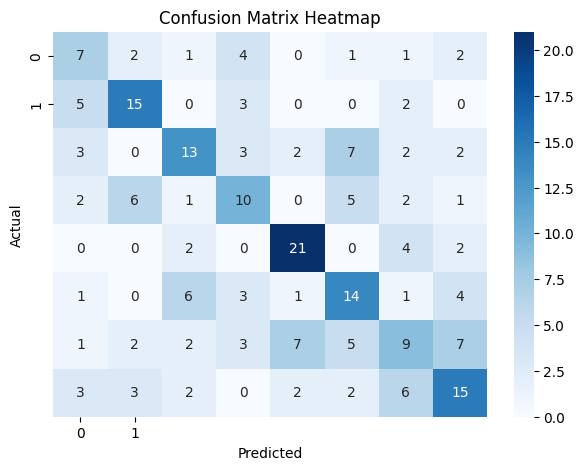

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example data (replace with your actual data)
y_true = y_test
y_pred = y_pred
class_labels = [0, 1]

# 1. Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 2. Plot using Seaborn heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='g', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')

# 3. Display the plot (essential for visualization in VS Code)
plt.show()


In [27]:
import joblib
import os

os.makedirs("models", exist_ok=True)

joblib.dump(model, "models/svc_emotion.joblib")


['models/svc_emotion.joblib']

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

models = {
    "random_forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "svm2": SVC(kernel="rbf", probability=True),
    "logistic": LogisticRegression(max_iter=1000)
}


In [29]:
from sklearn.metrics import accuracy_score

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    
    results[name] = acc
    
    joblib.dump(model, f"models/{name}_emotion.joblib")


e:\speech_analytics_system_for_contact_centres\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

joblib.dump(best_model, "models/best_emotion_model.joblib")


['models/best_emotion_model.joblib']

In [31]:
print(results)

{'random_forest': 0.5347826086956522, 'svm2': 0.23478260869565218, 'logistic': 0.41304347826086957}
